In [4]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [19]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [22]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Accessories (45),Accessories (45),Accessories (45),Accessories (45),Accessories (45),Accessories (45),Automotive
1,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,MN,Books and Media
2,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",Accessories > Bags (61),Accessories > Bags (61),Accessories > Bags (61),Accessories > Bags (61),Automotive
3,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,West bend,West bend,Health and Beauty
4,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Fashion


In [23]:
website_df["category"].count()

5189

In [24]:
classification_col = website_df["category"]

In [26]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    subset = subset.fillna("")
    subset = subset.astype(str)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        pattern = re.escape(phrase)
        phrase_count[phrase] = subset.str.count(pattern, flags=re.IGNORECASE)

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        phrase_count_sum = website_stats.sum()
        if phrase_count_sum == 0:
            continue
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (website_stats[phrase] / phrase_count_sum - alpha)
        year_score += y_n_numerator / y_n_denominator
        website_scores.append(y_n_numerator / y_n_denominator)
        website_category = classification_col[website]
        website_scores_by_category[website_category].append(y_n_numerator / y_n_denominator)
        websites_count += 1

    all_website_scores.append(website_scores)

    print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            print(f"Category {category} had no websites in year {year}")
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {year_score / websites_count}")

100%|██████████| 5189/5189 [00:01<00:00, 4275.67it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  328  Number of elements in website_scores:  328
Category Toys and Games had no websites in year 2007
Year 2007 score: 0.6067082884806286


100%|██████████| 5189/5189 [00:01<00:00, 4241.11it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  345  Number of elements in website_scores:  345
Category Toys and Games had no websites in year 2008
Year 2008 score: 0.6010773215140502


100%|██████████| 5189/5189 [00:01<00:00, 2860.00it/s]


Websites count:  451  Number of elements in website_scores:  451
Year 2009 score: 0.29114059931450625


100%|██████████| 5189/5189 [00:01<00:00, 4143.75it/s]


Websites count:  467  Number of elements in website_scores:  467
Year 2010 score: 0.3003418350546115


100%|██████████| 5189/5189 [00:01<00:00, 4371.48it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  325  Number of elements in website_scores:  325
Category Electronics had no websites in year 2011
Year 2011 score: 0.3436399895728811


100%|██████████| 5189/5189 [00:01<00:00, 4343.92it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  335  Number of elements in website_scores:  335
Category Electronics had no websites in year 2012
Year 2012 score: 0.32589207744464854


100%|██████████| 5189/5189 [00:01<00:00, 4270.88it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  302  Number of elements in website_scores:  302
Category Electronics had no websites in year 2013
Year 2013 score: 0.3852982931302775


100%|██████████| 5189/5189 [00:01<00:00, 4370.15it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  317  Number of elements in website_scores:  317
Category Electronics had no websites in year 2014
Year 2014 score: 0.37947491653069343


100%|██████████| 5189/5189 [00:01<00:00, 4129.43it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  428  Number of elements in website_scores:  428
Category Electronics had no websites in year 2015
Year 2015 score: 0.30781428319491805


100%|██████████| 5189/5189 [00:01<00:00, 4004.08it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  466  Number of elements in website_scores:  466
Category Electronics had no websites in year 2016
Year 2016 score: 0.3010587285357599


100%|██████████| 5189/5189 [00:01<00:00, 4201.50it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  411  Number of elements in website_scores:  411
Category Electronics had no websites in year 2017
Category Toys and Games had no websites in year 2017
Year 2017 score: 0.624368827102103


100%|██████████| 5189/5189 [00:01<00:00, 4188.36it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  415  Number of elements in website_scores:  415
Category Toys and Games had no websites in year 2018
Year 2018 score: 0.6545501202796008


100%|██████████| 5189/5189 [00:01<00:00, 3963.81it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  571  Number of elements in website_scores:  571
Category Toys and Games had no websites in year 2019
Year 2019 score: 0.6544919764919722


100%|██████████| 5189/5189 [00:01<00:00, 3800.99it/s]

Websites count:  606  Number of elements in website_scores:  606
Category Toys and Games had no websites in year 2020
Year 2020 score: 0.6392550611814917



/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [27]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])

[0.6067082884806285, 0.6010773215140502, 0.29114059931450614, 0.3003418350546113, 0.34363998957288105, 0.3258920774446485, 0.3852982931302778, 0.3794749165306937, 0.3078142831949177, 0.30105872853575966, 0.6243688271021045, 0.6545501202796019, 0.6544919764919717, 0.6392550611814918]


In [28]:
print([np.sum(scores) for scores in all_website_scores])

[199.00031862164616, 207.37167592234732, 131.30441029084227, 140.2596369705035, 111.68299661118634, 109.17384594395725, 116.3600845253439, 120.2935485402299, 131.74451320742477, 140.293367497664, 256.61558793896495, 271.6382999160348, 373.7149185769158, 387.38856707598404]


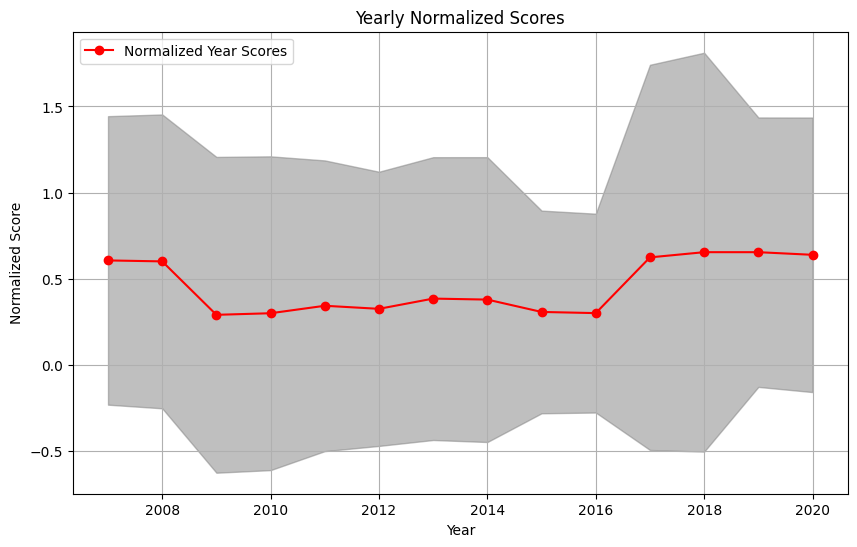

In [29]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]

plt.figure(figsize=(10, 6))
plt.plot(years, normalized_year_scores, marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Sum of Scores')

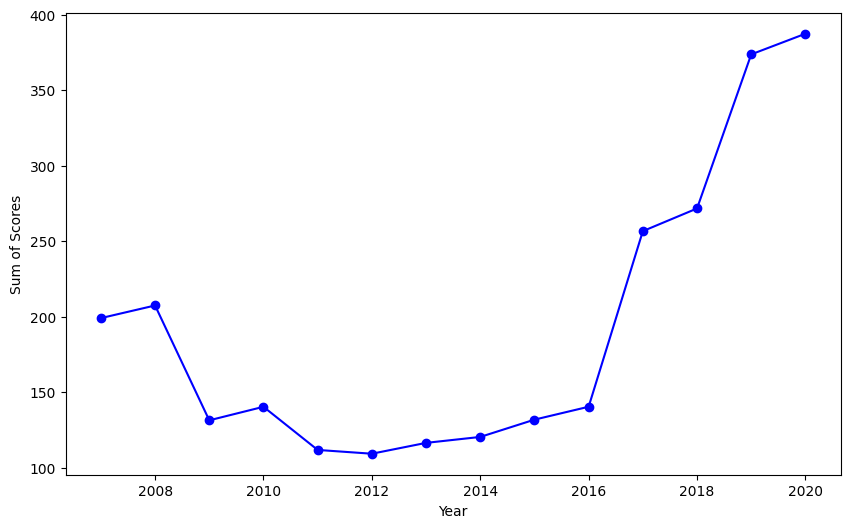

In [30]:
plt.figure(figsize=(10, 6))
value_sums = [np.sum(scores) for scores in all_website_scores]
plt.plot(years, value_sums, marker='o', color='b', label='Yearly Sums')
plt.xlabel('Year')
plt.ylabel('Sum of Scores')

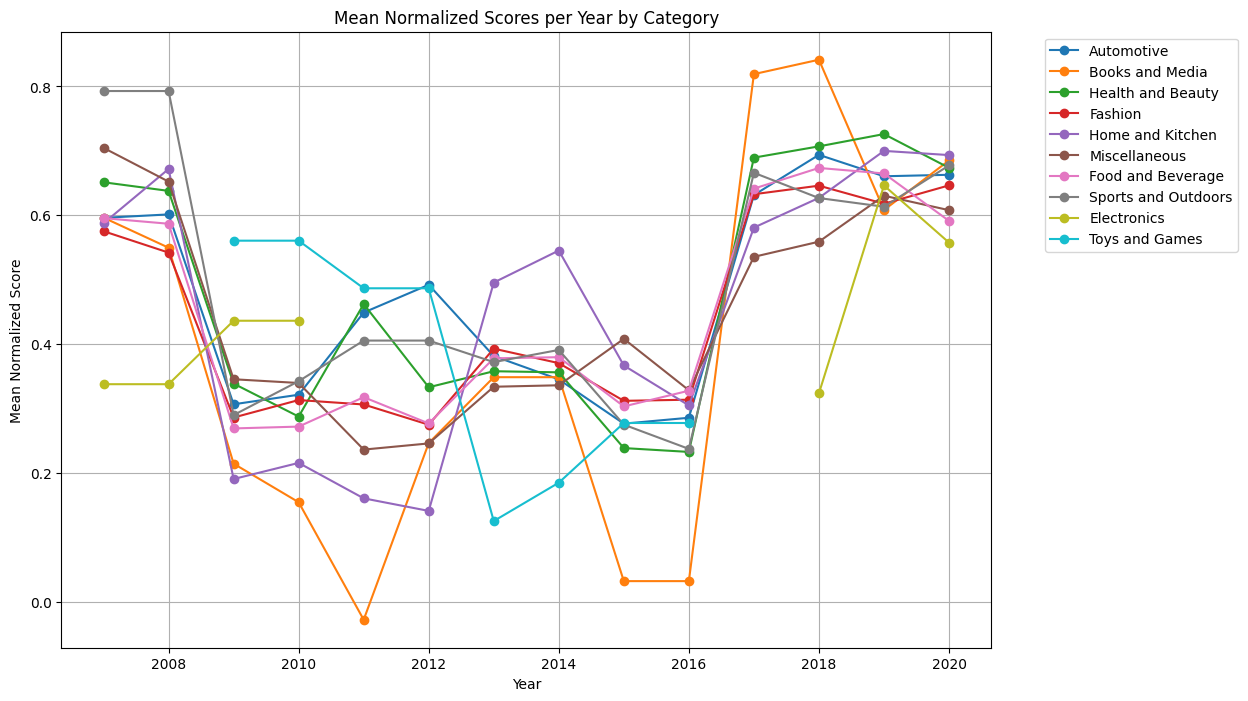

In [31]:
plt.figure(figsize=(12, 8))

for category, scores in categorized_normalized_year_scores.items():
    plt.plot(years, scores, marker='o', label=category)

plt.xlabel('Year')
plt.ylabel('Mean Normalized Score')
plt.title('Mean Normalized Scores per Year by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [63]:
classification_col.count()

2528